**Author: Gene Russol**

MSAI699 Capstone Project: Interpretability for Neural Tissue Modeling

April 24, 2025

Prof: Dr. Vinu Russell Viswasadhas

In [1]:
# Cell 1: Install dependencies

!pip install shap


In [2]:
# Cell 2: Imports

import pandas as pd
import numpy as np

from sklearn.compose        import ColumnTransformer
from sklearn.preprocessing  import StandardScaler, OneHotEncoder
from sklearn.impute         import SimpleImputer
from sklearn.pipeline       import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model    import LinearRegression
from sklearn.metrics        import mean_squared_error, mean_absolute_error, r2_score

import shap


In [3]:
# Cell 3: Data‑Loading & Further Cleaning

def load_data(filepath, target_col='restoration_score'):
    """
    Loads CSV, drops invalid binary column and zero‑variance features,
    returns X (features) and y (continuous target).
    """
    df = pd.read_csv(filepath)

    # drop metadata features
    df = df.drop(columns=['restoration_success','experiment_date', 'lab_id', 'protocol_version'], errors='ignore')

    # drop broken binary label
    df = df.drop(columns=[c for c in ['restoration_success'] if c in df.columns])
    # drop constant features
    df = df.loc[:, df.nunique() > 1]

    # split
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y


In [4]:
# Cell 4: Build Regression Pipeline

def build_regression_pipeline(X):
    """
    Imputes, encodes, scales, then fits LinearRegression.
    """
    num_feats = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats = X.select_dtypes(include=['object','category']).columns.tolist()

    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale',  StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

    preproc = ColumnTransformer([
        ('num', num_pipe, num_feats),
        ('cat', cat_pipe, cat_feats)
    ])

    return Pipeline([
        ('preproc', preproc),
        ('reg',     LinearRegression())
    ])

In [5]:
# Cell 5: Cross‑Validation & SHAP

def evaluate_regression_cv(X, y, pipeline, n_splits=5, random_state=42):
    """
    Runs KFold CV, prints per‑fold RMSE/MAE/R2, collects SHAP.
    Returns metrics_df, all_shap_vals, all_X_val_trans, feature_names.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    metrics, shap_vals_list, X_val_list = [], [], []

    for fold, (tr, va) in enumerate(kf.split(X), start=1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_va)

        rmse = np.sqrt(mean_squared_error(y_va, y_pred))
        mae  = mean_absolute_error(y_va, y_pred)
        r2   = r2_score(y_va, y_pred)
        print(f"Fold {fold}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
        metrics.append({'fold':fold,'rmse':rmse,'mae':mae,'r2':r2})

        # SHAP
        pre = pipeline.named_steps['preproc']
        reg = pipeline.named_steps['reg']
        X_tr_t  = pre.transform(X_tr)
        X_va_t  = pre.transform(X_va)
        feat_names = pre.get_feature_names_out(X.columns)

        explainer = shap.LinearExplainer(reg, X_tr_t, feature_perturbation='interventional')
        sv = explainer.shap_values(X_va_t)
        shap_vals_list.append(sv)
        X_val_list.append(X_va_t)

    metrics_df = pd.DataFrame(metrics).set_index('fold')
    print("\nCV metrics (mean ± std):")
    print(metrics_df.agg(['mean','std']).round(4))
    return metrics_df, shap_vals_list, X_val_list, feat_names

In [6]:
# Cell 6: Full‑Data Model & Metrics

def train_full_model(X, y, pipeline):
    """
    Fits on all data, prints overall RMSE/MAE/R2, returns pipeline and preds.
    """
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae  = mean_absolute_error(y, y_pred)
    r2   = r2_score(y, y_pred)
    print(f"Full‑data: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
    return pipeline, y_pred


In [7]:
# Cell 7: SHAP Summary Plot

def plot_shap_summary(all_shap_vals, all_X_vals, feature_names, max_display=10):
    """
    Aggregates SHAP values and displays a summary plot.
    """
    vals = np.vstack(all_shap_vals)
    data = np.vstack(all_X_vals)
    shap.summary_plot(vals, data,
                      feature_names=feature_names,
                      max_display=max_display)

Fold 1: RMSE=3.1437, MAE=2.0497, R²=0.9036
Fold 2: RMSE=3.6412, MAE=2.2269, R²=0.8630


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Fold 3: RMSE=2.9608, MAE=1.9030, R²=0.8982
Fold 4: RMSE=4.9606, MAE=2.4052, R²=0.7831


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Fold 5: RMSE=2.5856, MAE=1.8558, R²=0.9330

CV metrics (mean ± std):
        rmse     mae      r2
mean  3.4584  2.0881  0.8762
std   0.9217  0.2289  0.0577


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Full‑data: RMSE=2.8721, MAE=1.6982, R²=0.9178


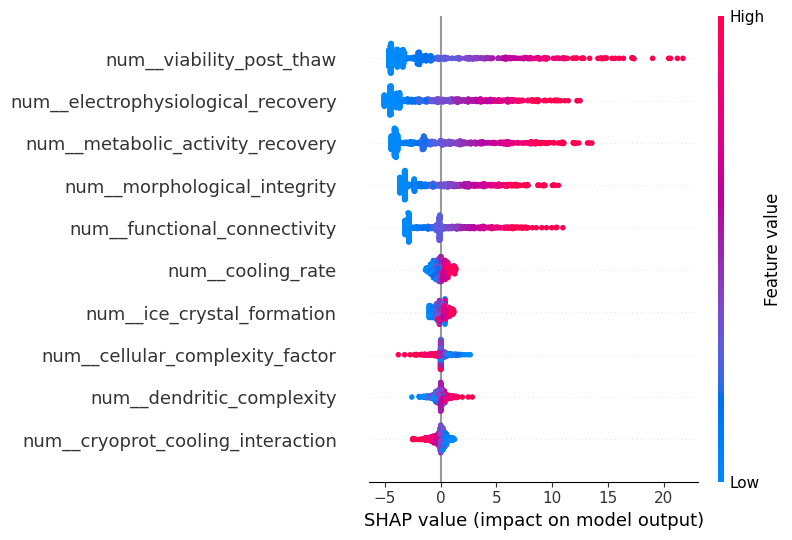

In [8]:
# Cell 8: Main Program

# 1) Point to your engineered CSV in the Files panel
fp = 'hybrid_neural_tissue_dataset-w 9 features engineered in AI Studio-no 1s.csv'

# 2) Load data
X, y = load_data(fp)

# 3) Build pipeline
pipeline = build_regression_pipeline(X)

# 4) Cross‑validate + SHAP
metrics_df, all_shap, all_X_vals, feat_names = evaluate_regression_cv(X, y, pipeline)

# 5) Train on full data
pipeline, y_full_pred = train_full_model(X, y, pipeline)

# 6) SHAP summary
plot_shap_summary(all_shap, all_X_vals, feat_names)


**BUILDING THE API SERVICE** (FNAL PRODUCT)

In [9]:
# Step 1. Install and import once (Run this cell once per Colab session.)

# install & imports
!pip install -q fastapi uvicorn pyngrok nest_asyncio shap

import nest_asyncio, json, pandas as pd, threading, requests
from fastapi import FastAPI
from pydantic import BaseModel
from pyngrok import ngrok
import uvicorn, shap




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.3 MB/s eta 0:00:00


In [10]:
# Step 2. Build the SHAP explainer and the FastAPI app

# Cell: explainer + endpoints
#
# 1) Build background data for SHAP
preproc       = pipeline.named_steps["preproc"]
X_background  = preproc.transform(X)      # full transformed data
explainer     = shap.LinearExplainer(pipeline.named_steps["reg"],
                                     X_background,
                                     feature_perturbation="interventional")
feature_names = preproc.get_feature_names_out(X.columns)

# 2) FastAPI definitions
app = FastAPI(title="Neural Restoration API")

class PredictRequest(BaseModel):
    data: dict            # raw feature_name : value

@app.post("/predict")
def predict(req: PredictRequest):
    df  = pd.DataFrame([req.data])
    xt  = preproc.transform(df)
    val = pipeline.named_steps["reg"].predict(xt)[0]
    return {"restoration_score": float(val)}

@app.post("/explain")
def explain(req: PredictRequest):
    df  = pd.DataFrame([req.data])
    xt  = preproc.transform(df)
    shap_vals = explainer.shap_values(xt)[0]
    return {"explanation": dict(zip(feature_names, map(float, shap_vals)))}


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [11]:
# Step 2a. Inserting new home() route for a more friendly landing page

from fastapi.responses import HTMLResponse

@app.get("/", include_in_schema=False)
def home():
    """Friendly landing page for non-technical visitors."""
    html = """
    <!DOCTYPE html><html>
      <head>
        <title>Neural Tissue Restoration API</title>
        <style>
            body {font-family: Arial, sans-serif; margin: 2rem; line-height: 1.6;}
            code {background:#f5f5f5; padding:2px 4px; border-radius:3px;}
            pre  {background:#f5f5f5; padding:1rem; border-radius:3px;}
            h2   {color:#006699;}
        </style>
      </head>
      <body>
        <h2>Neural Tissue Restoration API</h2>
        <p>
          This service can <strong>predict</strong> a restoration score for one tissue sample
          and <strong>explain</strong> which factors drove that prediction.
        </p>
        <ul>
          <li><code>POST /predict</code> — returns <em>restoration_score</em></li>
          <li><code>POST /explain</code> — returns SHAP attributions</li>
        </ul>
        <h3>Get started:</h3>
        <ol>
          <li>Click <a href="/docs">API Explorer (Swagger UI)</a>.</li>
          <li>Press “Try it out”, paste your JSON payload, then “Execute”.</li>
        </ol>
        <h3>Example JSON payload</h3>
        <pre>{
  "data": {
    "viability_predict_ratio": 1.3880272422749618,
    "gene_GRIN1": 4.376884703298932,
    "gene_GRIA1": 2.511423477375189,
    "organelle_disruption": 3.6296860699989457,
    "dna_damage": 1.3319745831048486,
    "restoration_efficiency_index": 1.278288847680198,
    "thawing_rate": 53.158280053872375,
    "ice_crystal_formation": 4.876505899499762,
    "osmotic_stress_level": 8.52751954257675,
    "temperature_transition_stress": 11.443151002664491,
    "cooling_rate": 9.606451509728902,
    "target_temperature": -115.55845682867258,
    "nucleation_temperature": -5.630381603070446,
    "cellular_complexity_factor": 3.432534379293956,
    "dendritic_complexity": 0.9966262511088848,
    "thaw_cool_efficiency": 5.533602079814435,
    "dendrite_soma_ratio": 143.89317396104323,
    "dendrite_length": 987.7796172497268,
    "soma_diameter": 6.864673215959169,
    "ice_cooling_interaction": 46.84591746045138,
    "membrane_thawing_interaction": 2814.057652812492,
    "membrane_integrity_loss": 52.93733450293411,
    "cryoprot_cooling_interaction": 120.47172189644888,
    "cryoprotectant_concentration": 12.540709935863577,
    "specimen_id": 1.0,
    "brain_region": "thalamus",
    "cell_type": "purkinje",
    "age": 31.0,
    "sex": "M",
    "input_resistance": 305.7266683107732,
    "resting_potential": -65.26087098581392,
    "threshold_voltage": -55.83517351243294,
    "capacitance": 102.24209893649034,
    "time_constant": 19.8658407814547,
    "axon_length": 2486.3088213538717,
    "dendrite_branches": 15.0,
    "gene_GRIA2": 2.8557849038391723,
    "gene_GRIA3": 2.966036774125727,
    "gene_GRIN2A": 3.725329831984233,
    "gene_GRIN2B": 1.326175619025153,
    "gene_GABRA1": 4.210966287586621,
    "gene_GABRB2": 1.8284923547710736,
    "gene_SLC6A1": 3.93186379793548,
    "cryoprotectant_type": "Glycerol",
    "penetration_time": 27.85787947881141,
    "freezing_duration": 3.569740029189437,
    "sample_volume": 4.745008492081834,
    "thawing_method": "Microwave",
    "post_thaw_dilution_ratio": 7.1097768017696215,
    "rewarming_protocol": "Standard",
    "intracellular_ice_damage": 3.458182656967149,
    "protein_denaturation": 81.98443517257338,
    "viability_post_thaw": 0.0,
    "metabolic_activity_recovery": 3.3639210293383286,
    "electrophysiological_recovery": 23.484570263225507,
    "morphological_integrity": 0.0,
    "functional_connectivity": 43.39155935306351,
    "experimental_group": "Treatment_C",
    "pretreatment": Null
  }
}</pre>
        <h3>Command-line (curl)</h3>
        <pre>curl -X POST "{root}predict" \\
  -H "Content-Type: application/json" \\
  -d @sample.json</pre>
        <p style="font-size:0.9em; margin-top:2rem;">
          Need help? Use the API Explorer or drop me a note.
        </p>
      </body>
    </html>
    """.replace("{root}", "/")  # ensures correct link
    return HTMLResponse(html)


In [12]:
# 1.For debugging only

import json

# take the first row as an example
payload = {"data": X.iloc[0].to_dict()}

# pretty-print it
print(json.dumps(payload, indent=2))



{
  "data": {
    "viability_predict_ratio": 1.3880272422749618,
    "gene_GRIN1": 4.376884703298932,
    "gene_GRIA1": 2.511423477375189,
    "organelle_disruption": 3.6296860699989457,
    "dna_damage": 1.3319745831048486,
    "restoration_efficiency_index": 1.278288847680198,
    "thawing_rate": 53.158280053872375,
    "ice_crystal_formation": 4.876505899499762,
    "osmotic_stress_level": 8.52751954257675,
    "temperature_transition_stress": 11.443151002664491,
    "cooling_rate": 9.606451509728902,
    "target_temperature": -115.55845682867258,
    "nucleation_temperature": -5.630381603070446,
    "cellular_complexity_factor": 3.432534379293956,
    "dendritic_complexity": 0.9966262511088848,
    "thaw_cool_efficiency": 5.533602079814435,
    "dendrite_soma_ratio": 143.89317396104323,
    "dendrite_length": 987.7796172497268,
    "soma_diameter": 6.864673215959169,
    "ice_cooling_interaction": 46.84591746045138,
    "membrane_thawing_interaction": 2814.057652812492,
    "membra

In [13]:
'''
# 2. For debugging only

# after you’ve loaded X in your notebook
features = X.columns.tolist()
print(len(features), "features:")
print(features)
'''

'\n# 2. For debugging only\n\n# after you’ve loaded X in your notebook\nfeatures = X.columns.tolist()\nprint(len(features), "features:")\nprint(features)\n'

In [14]:
'''
# 3. For debugging only

print("Raw features used:", X.columns.tolist())
print("Count of raw features:", X.shape[1])
'''

'\n# 3. For debugging only\n\nprint("Raw features used:", X.columns.tolist())\nprint("Count of raw features:", X.shape[1])\n'

In [15]:
'''
# 4. For debugging only

test_record = X.iloc[0].to_dict()
print(test_record)
'''

'\n# 4. For debugging only\n\ntest_record = X.iloc[0].to_dict()\nprint(test_record)\n'

In [16]:
# Step 3. Open one ngrok tunnel and launch Uvicorn

# expose & run
#ngrok.kill()                                       # close stale tunnels
ngrok.set_auth_token("2veP9j94j6zxVobVV9NnZHHltlP_7Di1m8AMcVvmdswcYT1HE")
ngrok.kill()                                       # close stale tunnels
public_url = ngrok.connect(8000)
print("🔗 Public URL:", public_url)

nest_asyncio.apply()                               # allow re-entrancy

def _run():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="error")

threading.Thread(target=_run, daemon=True).start()
print("✅ FastAPI is live; visit /docs for Swagger UI")



🔗 Public URL: NgrokTunnel: "https://8138-35-231-161-230.ngrok-free.app" -> "http://localhost:8000"
✅ FastAPI is live; visit /docs for Swagger UI
